# Computer Vision - P3

## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented.

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Comments need to be in **English**.

- The deliverable of both parts must be a file named **P3_Student1_Student2.zip** that includes:
    - The notebook P3_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
    - All the images used in this notebook.

**Deadline (Campus Virtual): November 1st, 23:00 h** 

==============================================================================================
## Practicum 3: Image and Video Segmentation

==============================================================================================

The main topics of Laboratory 3 are:

3.1. Segmentation of video shots with static scenes.

3.2. Background subtraction.

3.3. Segmentation of images.

The following chapters of the book “Computer Vision: Algorithms and Applicatons” from Richard Szeliski have further information about the topic:

* Chapter 4: Computer Vision: Algorithms and Applications.

* Chapter 5: Segmentation.



## Video segmentation

Given the video stored in ‘Barcelona-sequence’, which contains images acquired by a static camera, we ask you to:
- Find the temporal segments of the video (shots). Where the scene change? (Section 3.1)
- Extract the background images and thus, remove all the "artifacts" considered as foreground related to movement. (Section 3.2)




<img src="images/screenshot.png" width=600>

## 3.1 Segmentation of video shots

Read and visualize the sequence of images "images/Barcelona-sequence".

**Hint:** In order to read a collection of images, we wil use the function [animation.FuncAnimation](https://matplotlib.org/2.0.0/api/_as_gen/matplotlib.animation.FuncAnimation.html). Observe in the following Example, how FuncAnimation is used to read and visualize a sequence of frames. Explore the parameters of animation.FuncAnimation().

In [132]:
# Example
import numpy as np
import skimage
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.filters import median

from skimage import img_as_float
from skimage.exposure import histogram
from skimage.segmentation import felzenszwalb, slic, quickshift
from skimage.segmentation import mark_boundaries

In [133]:
def show_img(image,titol):
    """
    auxiliar function that plot an image with the corresponding title
    """
    plt.imshow(image, cmap='gray')
    plt.title(titol)
    plt.axis('off')
    plt.show()

In [175]:
def plot_images_line(images, titles):
    """
    function that shows the images on the same canvas with their corresponding titles
        images: list of images we want to plot together
        titles: list of corresponding titles of the images
    """
    canvas, axs = plt.subplots(nrows=1, ncols=len(images), figsize=(20,20))
    
    for index,image in enumerate(images):
        ax = axs[index]
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        ax.set_title(titles[index])

In [193]:
def plot_images(images,titles,ncols,video_seg = True):
    """
    Function that shows the images on the same canvas with their corresponding titles
        images: list of images we want to plot together
        titles: list of corresponding titles of the images
        ncols: number of columns
    """
    
    nrows = len(images)//ncols
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(15,15))
    
    index = 0
    for i in range(nrows):
        for j in range(ncols):
            ax = axs[i,j]
            if video_seg:
                ax.imshow(ic[images[index]])
            else:
                ax.imshow(images[index])
            ax.axis('off')
            ax.set_title(titles[index])
            index += 1
    plt.show()

In [185]:
#Changing the pluggin is necessary always when visualizing a video!
%matplotlib nbagg  

In [137]:
# Reading a sequence of images from a folder
ic = io.ImageCollection('images/Barcelona-sequence/*.png')

<IPython.core.display.Javascript object>


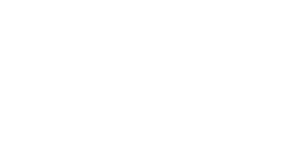

In [138]:
fig = plt.figure()  # Create figure
im = plt.imshow(ic[0], animated=True) #Visualize the first image

def run(i):   #Updating the frame visualization
    im.set_array(ic[i]) #Changing the content of the canvas
    return im, #to return a tuple!

plt.show()
ani = animation.FuncAnimation(fig, run, interval=1, blit=True, frames=len(ic), repeat= False)
plt.show()

a) Find where a shot (scene) finishes and the following starts (the shot boundaries). To achieve this goal, we are going to compute the difference between the histograms of consecutive frames. The proposed solution required:

- Compute the histogram for each RGB channel

- The 'total' histogram of the image is computed as the sum of the three histograms

- Compute the mean of the difference (in absolute value) between the histograms of two consecutive frames

Those differences with largest values corresponds to the transitions between shots. 

Therefore, **we need to create a funtion which return an array with the differences between histograms. We will plot the resulting array in order to localice the maximum values as well as a suitable threshold to define localize the transitions.**

<img src="images/histogramshot.png" width=600>
<img src="images/difference_histograms.png">

To solve this exercise, you need to create a **temporal plot** showing a frame by frame difference measure to be defined by you, being applicable to distinguish the shots. Define a criterion to detect the boundaries of the shots and visualize it in a static plot.

In [139]:
# Your solution here

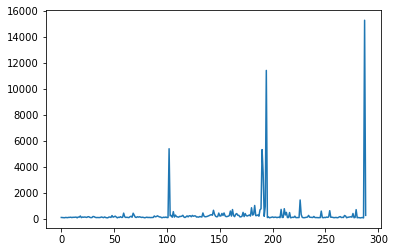

In [140]:
# Make plots appear and store within the notebook
%matplotlib inline

def compute_dif_hist(im, im_prev, hist_im_prev=None):
    """
    Function that create a temporal plot of the differences between frame and frame
    Parameters:
        im: current image
        im_prev: previous image
        hist_im_prev: ndarray histogram of the previous image 
    Return:
        hist_diff : value of the difference
        hist_im_prev: ndarray histogram of the previous frame 
    """
    # Compute the histogram for each RGB channel considering that the type of the image is uint8
    [hist_r, bins_r]=histogram((img_as_float(im)[:,:,0]),64)
    [hist_g, bins_g]=histogram((img_as_float(im)[:,:,1]),64)
    [hist_b, bins_b]=histogram((img_as_float(im)[:,:,2]),64)

    # The 'total' histogram of the image is computed as the sum of the three histograms
    hist_im = np.array(hist_r+hist_g+hist_b)
    
    # We will use this histogram for the next iteration, in this way we save calculations
    if hist_im_prev is None:
        [hist_r, bins_r]=histogram((img_as_float(im_prev)[:,:,0]),64)
        [hist_g, bins_g]=histogram((img_as_float(im_prev)[:,:,1]),64)
        [hist_b, bins_b]=histogram((img_as_float(im_prev)[:,:,2]),64)
        hist_im_prev = np.array(hist_r+hist_g+hist_b)
   
    # Compute the mean of the difference (in absolute value) between the histograms of two consecutive frames
    hist_diff = np.mean(np.abs(hist_im_prev - hist_im))
    
    return hist_diff, hist_im

def get_data():
    # Initialize the data arrays 
    xdata = []
    ydata = []
    # Initially the hist value of the prev is None
    prev_hist = None
    
    # Iterate through all the frames in our collection
    for t in range(len(ic)-1):
        # Update the data plot
        y, prev_hist = compute_dif_hist(ic[t+1], ic[t], prev_hist)
        # Frame index
        xdata.append(t) 
        # Value of difference between 2 frames
        ydata.append(y) 

    return [xdata,ydata]

data = get_data()
fig, ax = plt.subplots(1)
plt.plot(data[0], data[1])

b) Additionally, create an interactive plot executing the following code in "Example A". Substitute the bottom plot with the temporal plot showing the differences between the consecutive frames. 

In [141]:
# Example A
def data_gen():
    y = 0  ## Value of interest
    t = 0  ## Temporal value
    while True:
        t += 0.05
        y += 0.1
        yield t, y
        
def data_generator():
    """
    Generator whereby the data are calculated only when requested, in this way we save space
    """
    y_data = get_data()[1]
    t = 0
    for y in y_data:
        t += 1
        yield t, y

<IPython.core.display.Javascript object>


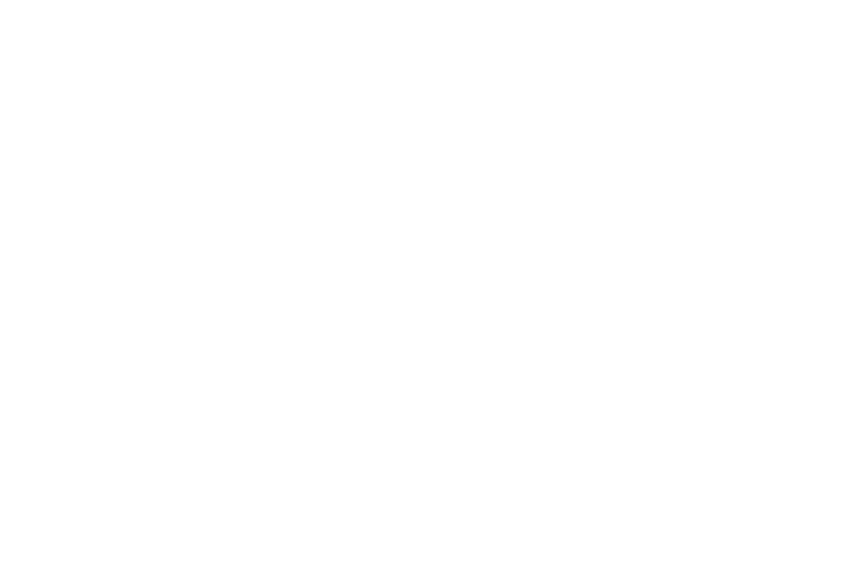

In [142]:
# Changing the pluggin is necessary always when visualizing a video!
%matplotlib nbagg  

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2,1)

# Intialize a line object on the second axes for plotting
line, = ax2.plot([], [], lw=2, color='r')

ax2.set_ylim(0, 1.1)
ax2.set_xlim(0, 5)
ax2.grid()

# Initialize the data arrays 
xdata, ydata = [], []

def run(data):
    # Update the data plot
    t, y = data
    xdata.append(t) # time = x axis
    ydata.append(y) # y axis

    # Plot image on top row
    ax1.imshow(ic[len(xdata)])
          
    # Plot sin in bottom row
    xmin, xmax = ax2.get_xlim()
    ymin, ymax = ax2.get_ylim()
    
    if t >= xmax:
        ax2.set_xlim(xmin, 2*xmax)
        ax2.figure.canvas.draw()
    
    if y >= ymax:
        ax2.set_ylim(ymin,2*ymax)
        ax2.figure.canvas.draw()
            
    # Update the data of both line objects
    line.set_data(xdata, ydata)

    return line

ani = animation.FuncAnimation(fig, run, data_generator, blit=True, interval=1, repeat=False)
plt.show()

<IPython.core.display.Javascript object>


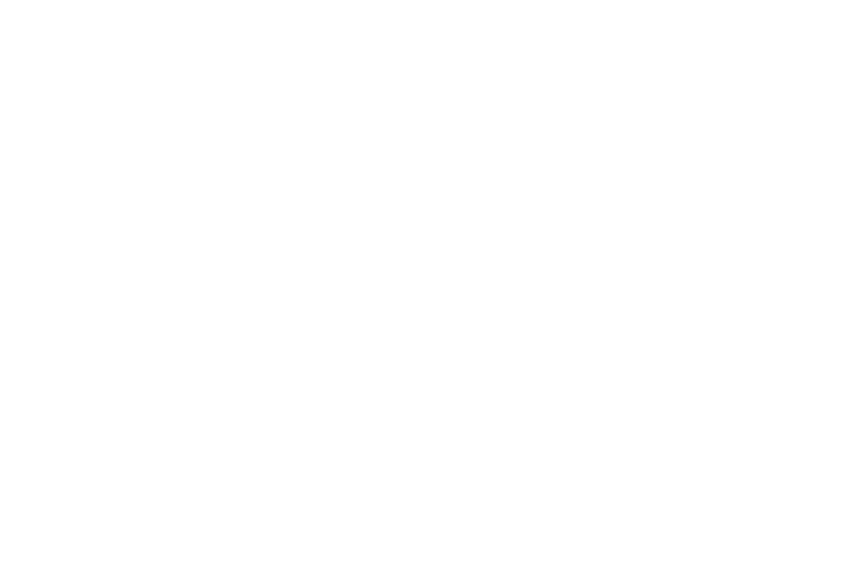

In [143]:
# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2,1)

# intialize a line object on the second axes for plotting
line, = ax2.plot([], [], lw=2, color='r')

ax2.set_ylim(0, 1.1)
ax2.set_xlim(0, 5)
ax2.grid()

# initialize the data arrays 
xdata, ydata = [], []
def run(data):
    # update the data plot
    t, y = data
    xdata.append(t) # time = x axis
    ydata.append(y) # y axis

    # Plot image on top row
    ax1.imshow(ic[len(xdata)])
          
    # Plot sin in bottom row
    xmin, xmax = ax2.get_xlim()
    ymin, ymax = ax2.get_ylim()
    
    if t >= xmax:
        ax2.set_xlim(xmin, 2*xmax)
        ax2.figure.canvas.draw()
    
    if y >= ymax:
        ax2.set_ylim(ymin,2*ymax)
        ax2.figure.canvas.draw()
            
    # update the data of both line objects
    line.set_data(xdata, ydata)

    return line

ani = animation.FuncAnimation(fig, run, data_gen, blit=True, interval=10, repeat=False)
plt.show()

In [144]:
# Your solution here

c) Show the initial and final images of each shot extracted as follows:

<img src="images_for_notebook/result_shot_detection.png">


Use the previous plot to define the proper threshold value over the differences of histograms. Use the threshold to localize indexes of the array returned by the function proposed in the previous question and, therefore, localize the initial and final frames for each shot.


In [145]:
# Your solution here

In [146]:
y_data = get_data()[1]

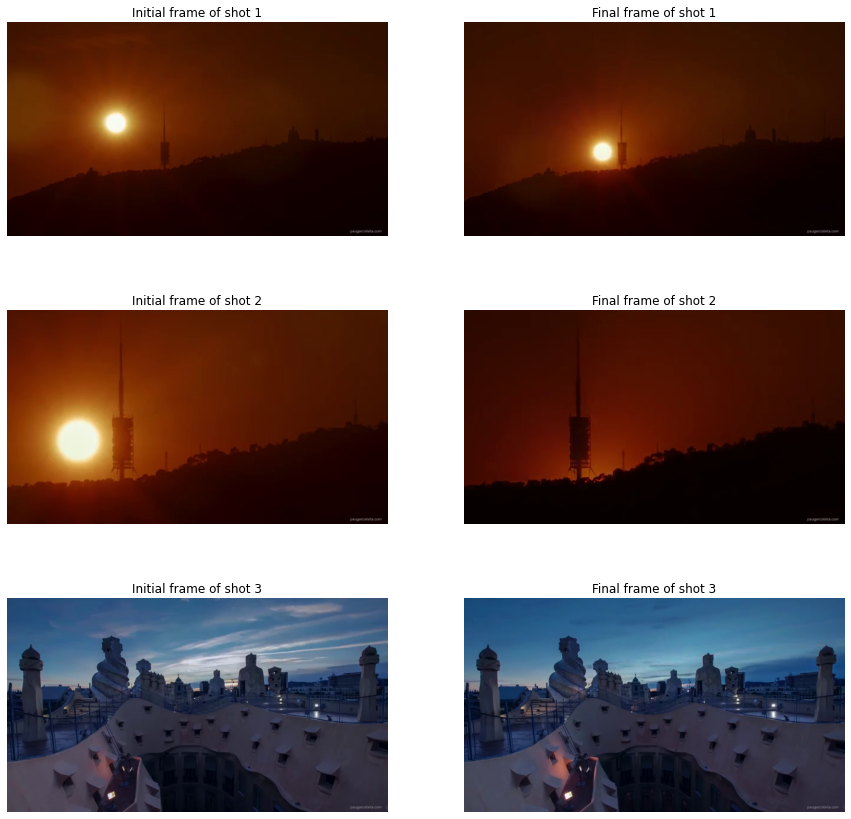

In [194]:
# Make plots appear and store within the notebook
%matplotlib inline

def index_ini_fin(y_data, nShots):
    """
    Function that plot the initial and final scenes of different shots we have
        y_data: list of means of the difference (in absolute value) between the histograms of two consecutive frames
        nShots: number of shots we have
    """
    # We get the indices of the peaks in the graph and sort them
    final = np.argsort(y_data)[-nShots:]
    final.sort()

    # And get the indices where the scenes start
    initial = []
    last = -1
    for i in final:
        initial.append(last+1)
        last = i
        
    return initial, final
    
    ''' images = [*initial,*final]
    images.sort()
    titles = ['Initial frame of shot 1','Final frame of shot 1', 'Initial frame of shot 2', 'Final frame of shot 2',
             'Initial frame of shot 3', 'Final frame of shot 3']
    
    plot_images(images,titles,2)'''

#plot_ini_fin(y_data,3)

# We get the index of the first and last images for plot them
initial, final = index_ini_fin(y_data, 3)
images = [*initial,*final]
images.sort()
titles = ['Initial frame of shot 1','Final frame of shot 1', 'Initial frame of shot 2', 'Final frame of shot 2',
          'Initial frame of shot 3', 'Final frame of shot 3']
# We plot the images using the parameter video_seg = True for get the images with the index
plot_images(images,titles,2)

d) Which measure have you used in order to visually distinguish the shots in a plot? Explain your solution.

According to what we have learn about shot boundaries, and through the list in which the mean of the differences between the histograms of two consecutive frames are presented to us, we can know that those peaks, or the highest values obtained of the list compared to the rest, corresponds to the transition between two shots.

In [148]:
# Your solution here

e) Would your video segmentation strategy be able to separate and track objects? Argue your answer.

It can not because we just study the histogram of the color pixel of each image, we do not study the form or the gradient, even the difference form between the first and the next one. But we con get from this algorithm some interesting information like the minimum change of color patterns, which told us that maybe the background of the shot have just small changes.

In [149]:
# Your solution here

f) Would your video segmentation strategy be able to capture continuous transition? Argue your answer.


In case the transition is very slow and smooth, we will not be able to distinguish it because the changes presented in the list of average differences will be more or less similar with the rest of the values. That means, there won't appreciate clears sudden changes of values.

In [150]:
# Your solution here

## 3.2 Background subtraction

Apply the background subtraction algorithm (check theory material).

<img src="images/screenshot2.png" width=500>

a) Visualize the following images for each different scene of the video:

    1) an image belonging to the shot
    2) the background image, and
    3) the foreground.
    
**Hint**: You can construct a mask obtained from the original image and the background in order to know which parts of the image form part from the foreground and recover from the original image just the foreground regions.

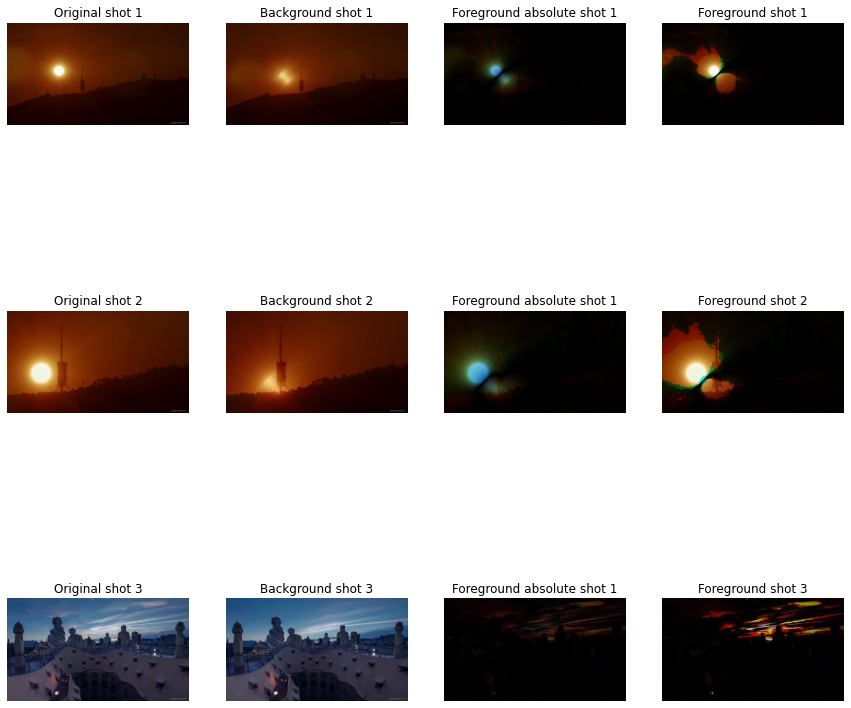

In [231]:
from skimage.filters import median
# Your solution here
# From the previous exercise we get the three diferent scenes and we apply the algorithm
# First we can define a function that plays the algorithm
'''
    Function that returns the 3 images of each scene video: original first image, background, foreground
        images: list of images that corresponds to one shot
        return: image original, background image, foreground image
'''
def backSub(ini, fin):
    # We inicializate a background image
    foreground, background = img_as_float(ic[ini]).copy(), img_as_float(ic[ini]).copy()

    # We create list for each channel beacuse we need to apply the median for each one
    red_channel = []
    green_channel = []
    blue_channel = []
    
    # Apply a median filter to all pixels along the temporal axis to estimate the background image (BI)
    
    # First we collect all the three channel from the images
    for i in range(ini, fin):
        red_channel.append(img_as_float(ic[i][:,:,0]))
        green_channel.append(img_as_float(ic[i][:,:,1]))
        blue_channel.append(img_as_float(ic[i][:,:,2]))
    #print(red_channel)
    # Now we need to apply median to a array of the temporal axis
    background[:,:,0] = np.median(red_channel, axis=0)
    #print(background)
    background[:,:,1] = np.median(green_channel, axis=0)
    background[:,:,2] = np.median(blue_channel, axis=0)
    #print(background)
    # Subtract BI from the current frame
    # Large absolute values are interesting pixels
    foregroundAbs = np.abs(img_as_float(ic[ini])-img_as_float(background))
    
    # Define a small threshold and get the original color foreground if necessary
    threshold = 0.1
    foreground = foregroundAbs.copy()
    foreground[:,:,0][foreground[:,:,0] > threshold] = img_as_float(ic[ini][:,:,0][foreground[:,:,0] > threshold])
    foreground[:,:,1][foreground[:,:,1] > threshold] = img_as_float(ic[ini][:,:,1][foreground[:,:,1] > threshold])
    foreground[:,:,2][foreground[:,:,2] > threshold] = img_as_float(ic[ini][:,:,2][foreground[:,:,2] > threshold])
    
    return ic[ini], background, foregroundAbs, foreground


# We generate the initial and last index of the shot using function index_ini_fin
initial, final = index_ini_fin(y_data, 3)
images = []

# Now we use the algorithm function for each shot, we have three shots
for i in range(3):
    image, background, foregroundAbs, foreground = backSub(initial[i], final[i])
    images.append(image)
    images.append(background)
    images.append(foregroundAbs)
    images.append(foreground)

# We visualise all the images
titles = ['Original shot 1','Background shot 1', 'Foreground absolute shot 1', 'Foreground shot 1', 
        'Original shot 2','Background shot 2', 'Foreground absolute shot 1', 'Foreground shot 2',
        'Original shot 3','Background shot 3', 'Foreground absolute shot 1', 'Foreground shot 3']
    
plot_images(images, titles, 4, False)
# The foreground shot depends on the threshold defined

b) What do the static background images represent? 

In [155]:
# The background image represents the pixels with no color changes in the timeline. That is when you apply the algorithm
# all the pixels will we nearly 0. Remenber we are looking for the foreground objects, those that have movement.

c) What happens if the shots are not correctly extracted? And, what happens if you find too many shots in the video? 

In [156]:
# When the shots are not correctly exacted we can not extract correctly the background, it is the same when we have
# lots of shots in the video, we do not have the same pixel en all images of the video sequence, so we can not find 
# the static pixel which represents the background of the video. Because the substraction will be affected.

d) What happens if you subtract the background image from the original one?

In [157]:
# If you substrat the finaly found background to each original image from the video, you can get a black one image
# (because you have a huge part with the same pixel color) with some small color changes, which means the objects that
# have movement in the video, and that is the foreground we are looking for.

e) In which situations does the algorithm work and in which it does not? Do you see any additional application for this algorithm?

In [158]:
# We just can apply this background substraction algorithm  in those images with no lighting changes.
# As we have said, the most important aspect to use this background substraction algorithm is you need a static
# background. That is we need a background that won't change the pixel in timeline. We need the same pixel or 
# similar to pick the median one (the highest value of pixel appered). If it change the color, when the time pass, 
# we will not choose and set the correct background pixel because the median would be affected.
# So, the algorithm work for static backgrounds and not for the timeline changes ones (we mean that there is anothe
# scene), and not for lighting changes during the time.

# Others applications of this algorithm can be the researching of inmovility objects, recognizing living beings, and
# then remove them, for example, remove a object from the desk if we now the background.

f) **[OPTIONAL]**
- Apply the algorithm to some other video that you found.

In [159]:
# We found a short video with the sequenced images and we apply the algorithm


## 3.3 Segmentation of images

Apply the image segmentation methods (Felzenswhalbs, Slic and Quickshift) based on the clustering of points corresponding to the pixels but in the feature space RGB-XY space.

**Hint**: 
- Different image segmentation commands can be found in skimage.segmentation.
- Use the function segmentation.mark_boundaries for seeing the boundaries of the segments.
- Use the inline pluggin to visualize images (%matplotlib inline).

<img src="images/image_Segmentation.png" width=600>

### Felzenszwalb's efficient graph based segmentation

a) Read 'rocki.jpeg' image from the folder 'images' and segment it using the Felzenszwalbs's method. Comment the result.


In [160]:
# Your solution here

In [161]:
# Make plots appear and store within the notebook
%matplotlib inline

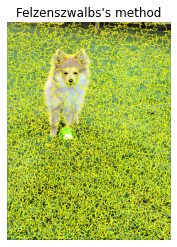

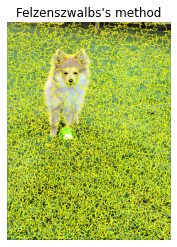

In [162]:
# Load image from images
rocki = io.imread('images/rocki.jpeg')
segments_fz = felzenszwalb(rocki, scale=100, sigma=0.5, min_size=50)
show_img(mark_boundaries(rocki, segments_fz),"Felzenszwalbs's method")

rocki = img_as_float(rocki)
# Segment rocki image using Felzenswalbs's method
segments_fz = felzenszwalb(rocki, scale=100, sigma=0.5, min_size=50)
show_img(mark_boundaries(rocki, segments_fz),"Felzenszwalbs's method")

b) Test and explore different parameters in order to obtain a good image segmentation up to you. 
Answer the following qüestions:
- Is it critical to convert the image in grayscale in order to do the image segmentation?

    If the image is in grayscale there are possibilities that different components will be missegmented into one component due to snooth changes in intensity.


- Is it critical to convert the image in float in order to do the image segmentation?

    If using the float values bring us more precision and accuracy, it will better to use it. But we have try that we get the same result using uint8 or float data types.
    
    
- Which are the optimal values according to your subjective perception?

    We will try to make the value of the sigma parameter lower, to be able to detect the difference between the floor and the bag of the dog, and a sufficient value for the rest of the parameters to separate the dog's body with the rest of the elements, in or case, we have configurated the parametres as: scale=600, sigma=0.1, min_size=100



- How does each parameter behave?

    The parameter scale sets an observation level, the larger this value, the larger the size of the split segments, so in the same image we will have less segments. Sigma is the diameter of a Gaussian kernel that smooths our image, as we can see, the edges are more continuous compared to the original, which can sometimes have consequences such as considering different parts of the image into one segment.And the min_size is the minimum size of the components, if we increase this number then the number of segments in the image will reduce.

Note: You can reduce the size of the image in order to accelerate the running. Does the image reduction affect the optimal values? 



In [163]:
# Your solution here
'''
2. If the gray color make more precise the boundaries it will be the better option, but it not the case, we can compare them.
2. We just need the more exactly method to use the algorithm, float images take more precision and accuracy, so it better to use it
Then, 
'''

'\n2. If the gray color make more precise the boundaries it will be the better option, but it not the case, we can compare them.\n2. We just need the more exactly method to use the algorithm, float images take more precision and accuracy, so it better to use it\nThen, \n'

In [164]:
segments_fz_0 = felzenszwalb(rocki, scale=100, sigma=0.5, min_size=50)
print(f"Felzenszwalb number of segments: {len(np.unique(segments_fz_0))}")

segments_fz_1 = felzenszwalb(rocki, scale=1000, sigma=0.5, min_size=50)
print(f"Felzenszwalb number of segments: {len(np.unique(segments_fz_1))}")

segments_fz_2 = felzenszwalb(rocki, scale=100, sigma=3.5, min_size=50)
print(f"Felzenszwalb number of segments: {len(np.unique(segments_fz_2))}")

segments_fz_3 = felzenszwalb(rocki, scale=100, sigma=0.5, min_size=500)
print(f"Felzenszwalb number of segments: {len(np.unique(segments_fz_3))}")

images = [mark_boundaries(rocki, segments_fz_0),mark_boundaries(rocki, segments_fz_1),
          mark_boundaries(rocki, segments_fz_2), mark_boundaries(rocki, segments_fz_3)]
titles = ['scale=100, sigma=0.5, min_size=50','scale=1000, sigma=0.5, min_size=50',
          'scale=100, sigma=3.5, min_size=50','scale=100, sigma=0.5, min_size=500']
plot_images(images,titles,2,False)

Felzenszwalb number of segments: 3711
Felzenszwalb number of segments: 502
Felzenszwalb number of segments: 586
Felzenszwalb number of segments: 376


TypeError: plot_images() missing 1 required positional argument: 'fig_size'

In [ ]:
'''
ESTO SE QUITARA 
'''
from skimage.color import rgb2gray

new = rocki.copy()
grayscale = rgb2gray(new)
plt.imshow(grayscale,cmap = 'gray')

segments = felzenszwalb(grayscale, scale=100, sigma=0.5, min_size=50)
plt.imshow(mark_boundaries(grayscale, segments))

In [ ]:
'''
ESTO SE QUITARA 
'''
new = io.imread('images/dog.jpg')
segments = felzenszwalb(new, scale=600, sigma=0.1, min_size=100)
plt.imshow(mark_boundaries(new, segments))

c) Comment the definition of the algorithm (use approximately 3 lines at most), its advantages and disadvantages.

Produces over-segmentation using fast and minimal clustering based on a spanning tree on the image grid.
Advantages: able to place highly varying regions into the same segment while capturing global image features, also preserves small components like name tags and numbers. Disadvantages: sometimes non spatially connection regions or where there are slow change of intensity are placed in the same component.

In [ ]:
# Your solution here

### SLIC - K-Means based image segmentation
d) Segment the same image using the SLIC image segmentation algorithm using the parameters by default. 

In [ ]:
# Your solution here

In [ ]:
# Segment rocki image 
segments_slic = slic(rocki, start_label=1)
show_img(mark_boundaries(rocki, segments_slic),"SLIC-K-Means's method")

e) Explore what are the parameters of the slic function. Test different values for these parameters in order to obtain a good image segmentation with SLIC algorithm.
Answer the following qüestions:
- Is it critical to convert the image in grayscale in order to do the image segmentation?

    The same as the felsenzw algorithm, if



- Is it critical to convert the image in float in order to do the image segmentation?

    


- Which are the optimal values of the optional valriables?

    


- How does each parameter behave?

    The n_segments indicates the approximate number of segment that the image will have, the compacteness indicates the balances color proximity and space proximity, the higher this value, the more square/cubic the superpixel shapes will be. And sigma is still an image smoothing tool making the edges of the components smoother.

In [ ]:
# Your solution here

In [ ]:
segments_slic_0 = slic(rocki, n_segments=100, compactness=10, sigma=1, start_label=1)
print(f"SLIC number of segments: {len(np.unique(segments_slic_0))}")

segments_slic_1 = slic(rocki, n_segments=500, compactness=10, sigma=1, start_label=1)
print(f"SLIC number of segments: {len(np.unique(segments_slic_1))}")

segments_slic_2 = slic(rocki, n_segments=100, compactness=20, sigma=1, start_label=1)
print(f"SLIC number of segments: {len(np.unique(segments_slic_2))}")

segments_slic_3 = slic(rocki, n_segments=100, compactness=10, sigma=5, start_label=1)
print(f"SLIC number of segments: {len(np.unique(segments_slic_3))}")

images = [mark_boundaries(rocki, segments_slic_0),mark_boundaries(rocki, segments_slic_1),
         mark_boundaries(rocki, segments_slic_2),mark_boundaries(rocki, segments_slic_3)]
titles = ['n_segments=100, compactness=10, sigma=1 ','n_segments=500, compactness=10, sigma=1 ',
          'n_segments=100, compactness=20, sigma=1 ','n_segments=100, compactness=10, sigma=5']
plot_images(images,titles,2,False)


In [ ]:
'''
ESTO SE QUITARA
'''
new = rocki.copy()
grayscale = rgb2gray(new)
plt.imshow(grayscale,cmap = 'gray')

segments = slic(rocki, n_segments=100, compactness=10, sigma=5, start_label=1)
plt.imshow(mark_boundaries(grayscale, segments))
#NO TROBO DIFERENCIA

In [ ]:
'''
ESTO SE QUITARA
'''
new = io.imread('images/rocki.jpeg')
segments = slic(rocki, n_segments=100, compactness=20, sigma=0, start_label=1)
plt.imshow(mark_boundaries(new, segments))

f) Comment what the algorithm is (in up to 3 lines).

   As his name said, k-means clustering algorithm, is based on the idea to split or separate all the data we have in k groups, by studing their features, in that case the distance between pixels. The algorithm tries to have the clusters as far possible from the others. Is that we can have a "classification" of this neighbors to said them are from different object.

In [ ]:
# Your solution here

### Quickshift image segmentation

g) Segment the same image using the Quickshift algorithm. 

In [ ]:
# Your solution here

In [ ]:
segments_quick = quickshift(rocki)
show_img(mark_boundaries(rocki, segments_quick),"Quickshift's method")

h) Test different parameters in order to obtain a good image segmentation with Quickshift algorithm.
Answer the following qüestions:
- Which are the optimal values?
- How does each parameter behave?

In [ ]:
# Your solution here

In [ ]:
segments_quick_0 = quickshift(rocki, kernel_size=10, ratio=1, max_dist=10)
print(f"Quickshift number of segments: {len(np.unique(segments_quick_0))}")

segments_quick_1 = quickshift(rocki, kernel_size=15, ratio=1, max_dist=10)
print(f"Quickshift number of segments: {len(np.unique(segments_quick_1))}")

segments_quick_2 = quickshift(rocki, kernel_size=10, ratio=0.01, max_dist=10)
print(f"Quickshift number of segments: {len(np.unique(segments_quick_2))}")

segments_quick_3 = quickshift(rocki, kernel_size=10, ratio=1, max_dist=20)
print(f"Quickshift number of segments: {len(np.unique(segments_quick_3))}")

images = [mark_boundaries(rocki, segments_quick_0),mark_boundaries(rocki, segments_quick_1),
         mark_boundaries(rocki, segments_quick_2),mark_boundaries(rocki, segments_quick_3)]
titles = ['kernel_size=10, ratio=1, max_dist=10 ','kernel_size=20, ratio=1, max_dist=1 ',
          'kernel_size=10, ratio=0.01, max_dist=1 ','kernel_size=10, ratio=1, max_dist=20']
plot_images(images,titles,2,False)

In [ ]:
'''
ESTO SE QUITARA
'''
new = io.imread('images/dog.jpg')
segments = quickshift(new, kernel_size=10, ratio=1, max_dist=10)
plt.imshow(mark_boundaries(new, segments))

i) Comment what the algorithm is (in up to 3 lines).

   Like the others two, quickshift is also a clustering algorithm, and better tham them. It is based on finding the most density espace from the neighbors. It is like a mean shift looking algorithm...

In [ ]:
# Your solution here

### Comparison of segmentation algorithms
j) Plot the original image and the results of both algorithms in a 1x3 subplot using the optimal values.

In [ ]:
# Your solution here

In [ ]:
show_img(rocki,"Original")
# Get the segments using the optimal values
seg_fel = felzenszwalb(rocki, scale=600, sigma=0.1, min_size=100)
seg_slic = slic(rocki, n_segments=100, compactness=20, sigma=0, start_label=1)
seg_qui = quickshift(rocki, kernel_size=10, ratio=1, max_dist=10)

# Show images
images = [mark_boundaries(rocki, seg_fel),mark_boundaries(rocki, seg_slic),mark_boundaries(rocki, seg_qui)]
titles = ["Felzenszwalbs's method","SLIC-K-Means's method","Quickshift's method"]
plot_images_line(images,titles)

k) Calculate also the number of segments obtained on the image by each of the algorithms. Can the number of segments can be used as a criterion for the performance of the algorithms?

In [ ]:
# Your solution here

In [ ]:
print(f"Felzenszwalb number of segments: {len(np.unique(seg_fel))}")
print(f"SLIC number of segments: {len(np.unique(seg_slic))}")
print(f"Quickshift number of segments: {len(np.unique(seg_qui))}")

l) Comment the differences between each method as well as their advantages and disadvantages.

       Method         |          Advantages                      |            Disadvantages
       ---------------------------------------------------------------------------------------------------------
       
        

In [ ]:
# Your solution here

m) Choose another couple of color and grayscale images from the folder 'images' as well as from internet and apply the three segmentation methods. Comment the results.

In [ ]:
# Your solution here

In [ ]:
'''
FALTA FER PROVES PER GRAYSCALE 
'''
# Load images from images
doulphin = io.imread('images/doulphin.jpg')
loro = io.imread('images/loro.png')

segments = felzenszwalb(loro, scale=600, sigma=0.1, min_size=100)
loro_felz = mark_boundaries(loro, segments)
segments = slic(loro, n_segments=100, compactness=20, sigma=0, start_label=1)
loro_slic = mark_boundaries(loro, segments)
segments = quickshift(loro, kernel_size=10, ratio=1, max_dist=10)
loro_quick = mark_boundaries(loro, segments)

images_loro = [loro,loro_felz,loro_slic,loro_quick]
titles_loro = ['loro','loro_felz','loro_slic','loro_quick']

plot_images(images_loro,titles_loro,2,False)